In [1]:
#Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skopt.plots import plot_convergence

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, precision_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from skopt.searchcv import BayesSearchCV #pip install scikit-optimize
import warnings 

warnings.filterwarnings("ignore") #Ignore the numerous warnings by the bayesian search
%matplotlib inline

In [2]:
#Read the dataset
df=pd.read_csv('adult.csv')
#The number of samples is 48842 and features is 15.
df.shape

(48842, 15)

In [3]:
#Show the first five samples
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


## Data Pre-Processing

### Handling Null Values
        As we can see from the data, any unknown values are listed with a '?'. First we will replace the '?' with a NaN null value. Then we will handle the null values by removing all the samples which have null values.

In [4]:
#Null values before replacing '?'
df.isnull().sum()

age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

In [5]:
#Loop through the dataframe and replace '?'
df.replace('?',value=np.NaN, inplace=True)
#Show the first five samples
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


In [6]:
#Null values after replacing '?'
df.isnull().sum()

age                   0
workclass          2799
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2809
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      857
income                0
dtype: int64

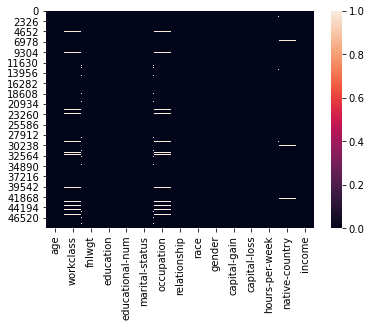

In [7]:
#Visualize null values in the dataset. 
#Heatmap before removing null values
sns.heatmap(df.isnull())

In [8]:
#Drop all the rows which contain null values.
#We are dropping only the samples as its the minimum data we will have to remove to remove any null values in our dataset,
#whereas dropping by column would make us loose significant  amount of information here
df.dropna(subset=['workclass'], how='any',inplace=True) 
df.dropna(subset=['occupation'], how='any',inplace=True)
df.dropna(subset=['native-country'], how='any',inplace=True)
df.shape #The number of smaples reduces from 48842 to 45222

(45222, 15)

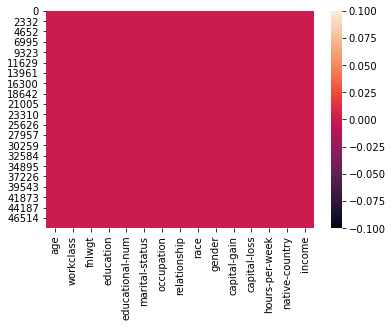

In [9]:
#Visualize null values in the dataset.
#Heatmap afetr removing null values.
sns.heatmap(df.isnull())

### Handling non-numerical and categorical values.
          We will first look at all the dtypes in the dataset. If there exists any non-numerical or categorical values, then we will convert them by using LabelEncoder(). Another option would be to use pd.get_dummies() and then dropping and concataneting as nessecary.

In [10]:
#Find the dtypes of the features
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45222 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              45222 non-null  int64 
 1   workclass        45222 non-null  object
 2   fnlwgt           45222 non-null  int64 
 3   education        45222 non-null  object
 4   educational-num  45222 non-null  int64 
 5   marital-status   45222 non-null  object
 6   occupation       45222 non-null  object
 7   relationship     45222 non-null  object
 8   race             45222 non-null  object
 9   gender           45222 non-null  object
 10  capital-gain     45222 non-null  int64 
 11  capital-loss     45222 non-null  int64 
 12  hours-per-week   45222 non-null  int64 
 13  native-country   45222 non-null  object
 14  income           45222 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.5+ MB


     As we can see, the features 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country', and the target 'income' are categorical values. Therefore before applying a label encoder, we will look at all the unique values and the number of times a unique value occurs, in each column

In [11]:
#No. of unique values in 'workclass' and the number of times each unique value occurs.
df['workclass'].value_counts()

Private             33307
Self-emp-not-inc     3796
Local-gov            3100
State-gov            1946
Self-emp-inc         1646
Federal-gov          1406
Without-pay            21
Name: workclass, dtype: int64

In [12]:
#No. of unique values in 'education' and the number of times each unique value occurs.
df['education'].value_counts()

HS-grad         14783
Some-college     9899
Bachelors        7570
Masters          2514
Assoc-voc        1959
11th             1619
Assoc-acdm       1507
10th             1223
7th-8th           823
Prof-school       785
9th               676
12th              577
Doctorate         544
5th-6th           449
1st-4th           222
Preschool          72
Name: education, dtype: int64

In [13]:
#No. of unique values in 'marital-status' and the number of times each unique value occurs.
df['marital-status'].value_counts()

Married-civ-spouse       21055
Never-married            14598
Divorced                  6297
Separated                 1411
Widowed                   1277
Married-spouse-absent      552
Married-AF-spouse           32
Name: marital-status, dtype: int64

In [14]:
#No. of unique values in 'occupation' and the number of times each unique value occurs.
df['occupation'].value_counts()

Craft-repair         6020
Prof-specialty       6008
Exec-managerial      5984
Adm-clerical         5540
Sales                5408
Other-service        4808
Machine-op-inspct    2970
Transport-moving     2316
Handlers-cleaners    2046
Farming-fishing      1480
Tech-support         1420
Protective-serv       976
Priv-house-serv       232
Armed-Forces           14
Name: occupation, dtype: int64

In [15]:
#No. of unique values in 'relationship' and the number of times each unique value occurs.
df['relationship'].value_counts()

Husband           18666
Not-in-family     11702
Own-child          6626
Unmarried          4788
Wife               2091
Other-relative     1349
Name: relationship, dtype: int64

In [16]:
#No. of unique values in 'race' and the number of times each unique value occurs.
df['race'].value_counts()

White                 38903
Black                  4228
Asian-Pac-Islander     1303
Amer-Indian-Eskimo      435
Other                   353
Name: race, dtype: int64

In [17]:
#No. of unique values in 'gender' and the number of times each unique value occurs.
df['gender'].value_counts()

Male      30527
Female    14695
Name: gender, dtype: int64

In [18]:
#No. of unique values in 'native-country' and the number of times each unique value occurs.
df['native-country'].value_counts()

United-States                 41292
Mexico                          903
Philippines                     283
Germany                         193
Puerto-Rico                     175
Canada                          163
El-Salvador                     147
India                           147
Cuba                            133
England                         119
China                           113
Jamaica                         103
South                           101
Italy                           100
Dominican-Republic               97
Japan                            89
Guatemala                        86
Vietnam                          83
Columbia                         82
Poland                           81
Haiti                            69
Portugal                         62
Iran                             56
Taiwan                           55
Greece                           49
Nicaragua                        48
Peru                             45
Ecuador                     

In [19]:
#No. of unique values in the target 'income' and the number of times each unique value occurs.
df['income'].value_counts()

<=50K    34014
>50K     11208
Name: income, dtype: int64

In [20]:
#Apply the label encoder to transfrom categorical values
df = df.apply(LabelEncoder().fit_transform) 
#Dataset after transformation                                                      
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,8,2,18119,1,6,4,6,3,2,1,0,0,39,38,0
1,21,2,3913,11,8,2,4,0,4,1,0,0,49,38,0
2,11,1,23770,7,11,2,10,0,4,1,0,0,39,38,1
3,27,2,10474,15,9,2,6,0,2,1,96,0,39,38,1
5,17,2,15397,0,5,4,7,1,4,1,0,0,29,38,0


### Splitting Dataset

In [21]:
#Split dataset into dataframes with the target and without the target.
X=df.drop('income',axis=1)
y=df['income']
print(X.shape)
print(y.shape)

(45222, 14)
(45222,)


## KNN Without Feature Selection or Feature Scaling

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
#create training models: split data into training and testing sets
#test percenatge is 25%
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(33916, 14)
(33916,)
(11306, 14)
(11306,)


In [23]:
#Fit the training test
KNN = KNeighborsClassifier(n_neighbors=1) #number of nearest neighbors is 1 here
KNN.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

#### Accuracy of KNN without feature scaling or feature selection

In [24]:
print("Training score = {:.3f}\n Testing score = {:.3f}".format(KNN.score(X_train,y_train), KNN.score(X_test,y_test)))

Training score = 1.000
 Testing score = 0.726


## With Feature Selection and Feature Scaling

### Feature Selection

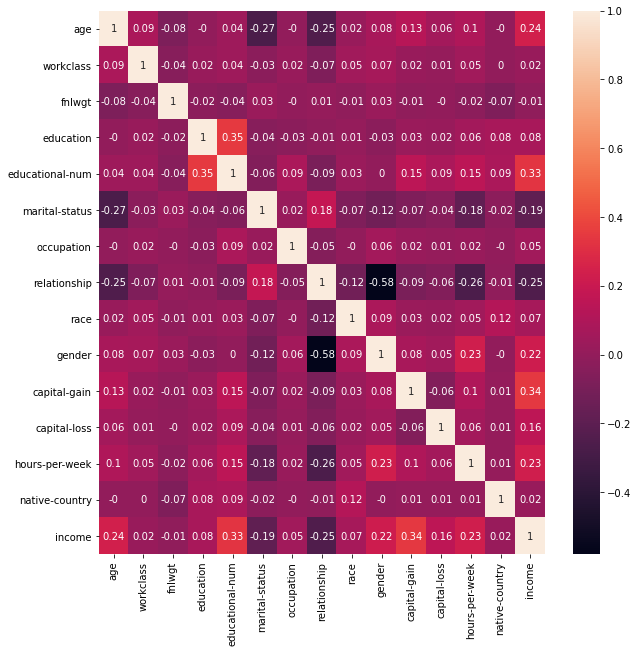

In [25]:
#Heatmap to visualize correlation between the columns 
plt.figure(figsize=(10,10))
correlation_matrix = df.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True)

                 As we can see from the heatmap, the target income'ss correlation to other columns in a descending order is: 'capital_gain (0.34)' , 'educational-num (0.33)', 'age (0.24)', 'hours-per-week (0.23)', 'gender (0.22)', 'capital-loss (0.16)', 'education (0.08)', 'race (0.07)', 'occupation (0.05)', 'workclass (0.02)', 'native-country (0.02)','fnlwgt (-0.01)',    'martial-status (-0.19)', 'relationship (-0.25)'.
                Based on the above let us split data without the last three features which have the least correlation, that is correlation in negative value. We also remove the least impacting workclass and native-country features. Therefore we select 9 out of 15 features.

In [26]:
X1=df[['capital-gain','educational-num','age','hours-per-week','gender','capital-loss','education','race','occupation']]
y1=df['income']
print(X1.shape)
print(y1.shape)

(45222, 9)
(45222,)


In [27]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.25, random_state=0)
#create training models: split data innto training and testing sets
#test percenatge is 25%
print(X1_train.shape)
print(y1_train.shape)
print(X1_test.shape)
print(y1_test.shape)

(33916, 9)
(33916,)
(11306, 9)
(11306,)


### Accuracy of KNN with feature selection

In [28]:
#Fit the training test 
KNN1 = KNeighborsClassifier(n_neighbors=1) #number of nearest neighbors is 1 here
KNN1.fit(X1_train, y1_train)
print("Training score = {:.3f}\n Testing score = {:.3f}".format(KNN1.score(X1_train,y1_train), KNN1.score(X1_test,y1_test)))

Training score = 0.922
 Testing score = 0.770


### Feature Scaling- Standard, MinMax, Robust Scaler

In [29]:
#scaling data using the standard scaler
sc=StandardScaler()
XS_train= sc.fit_transform(X1_train)
XS_test= sc.fit_transform(X1_test)

In [30]:
#Fit the training test 
KNN_FS1=KNeighborsClassifier(n_neighbors=1) #number of nearest neighbors is 1 here
KNN_FS1.fit(XS_train,y1_train)

KNeighborsClassifier(n_neighbors=1)

In [31]:
#scaling data using the minmax scaler
mc=MinMaxScaler()
XM_train= mc.fit_transform(X1_train)
XM_test= mc.fit_transform(X1_test)

In [32]:
#Fit the training test 
KNN_FS2=KNeighborsClassifier(n_neighbors=1) #number of nearest neighbors is 1 here
KNN_FS2.fit(XM_train,y1_train)

KNeighborsClassifier(n_neighbors=1)

In [33]:
#scaling data using the robust scaler
rc=RobustScaler()
XR_train= rc.fit_transform(X1_train)
XR_test= rc.fit_transform(X1_test)

In [34]:
#Fit the training test with
KNN_FS3=KNeighborsClassifier(n_neighbors=1) #number of nearest neighbors is 1 here
KNN_FS3.fit(XR_train,y1_train)

KNeighborsClassifier(n_neighbors=1)

#### Accuracy of KNN with feature scaling and standard scaler

In [35]:
print("Training score = {:.3f}\n Testing score = {:.3f}".format(KNN_FS1.score(XS_train,y1_train), KNN_FS1.score(XS_test,y1_test)))

Training score = 0.922
 Testing score = 0.773


#### Accuracy of KNN with feature scaling and minmax scaler

In [36]:
print("Training score = {:.3f}\n Testing score = {:.3f}".format(KNN_FS2.score(XM_train,y1_train), KNN_FS2.score(XM_test,y1_test)))

Training score = 0.922
 Testing score = 0.773


#### Accuracy of KNN with feature scaling and robust scaler

In [37]:
print("Training score = {:.3f}\n Testing score = {:.3f}".format(KNN_FS3.score(XR_train,y1_train), KNN_FS3.score(XR_test,y1_test)))

Training score = 0.924
 Testing score = 0.797


        As we can see from above, model with feature scaling and all three types of scalers has similar training and testing score. Out of the three the model with robust scaling has the highest training and testing score. Therefore, for further use we will use the robust scaled training and testing sets, XR_train, y1_train, XR_test and y1_test.

## Confusion Matrix

In [38]:
#Predicting values of the testing set
#As mentioned above, we are using the feature selected dataframes with the robust scaled sets and the model fitted with the robust scaled data. 
y1_test_pred=KNN_FS3.predict(XR_test)
#Compare predicted values with actual values using a confusion matrix
cmat= confusion_matrix(y1_test,y1_test_pred)
print(cmat)

[[7376 1091]
 [1205 1634]]


Confusion matrix without normalization
[[7376 1091]
 [1205 1634]]
Confusion matrix with normalization
[[0.87114681 0.12885319]
 [0.42444523 0.57555477]]


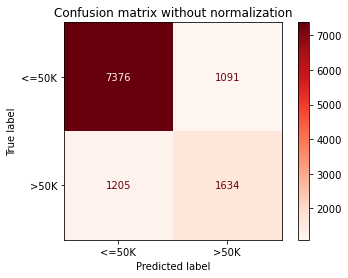

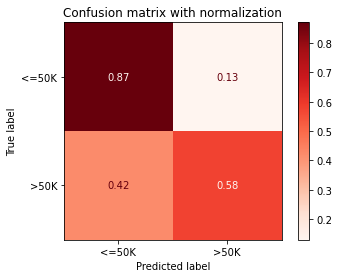

In [39]:
titles_options = [('Confusion matrix without normalization', None), ('Confusion matrix with normalization', 'true')]
#Measure the normalised and non-normlised confusion matrices
for title, normalization in titles_options:
    cm_plt = plot_confusion_matrix(KNN_FS3, XR_test, y1_test, display_labels = ['<=50K','>50K'], cmap=plt.cm.Reds, normalize = normalization)
    cm_plt.ax_.set_title(title)
    print(title)
    print(cm_plt.confusion_matrix)
#Plot the confusion matrices   
plt.show()

## Evaluation Metrics

In [40]:
#Measure the evaluation metrics for the actual and predicted values
#The values have been predicted against the model fitted with feature selected and robust scaled traning sets
pd.DataFrame(data=[[accuracy_score(y1_test,y1_test_pred), recall_score(y1_test,y1_test_pred),
                   precision_score(y1_test,y1_test_pred), roc_auc_score(y1_test, y1_test_pred)]],
            columns=["accuracy","recall","precision","roc_auc_score"],
            index=['Score'])

,accuracy,recall,precision,roc_auc_score
Score,0.796922,0.575555,0.599633,0.723351


## Classification Report

In [41]:
#Use a classification report to print the evaluation metrics for each classification label(<=50K,>50K)
cReport = classification_report(y1_test,y1_test_pred,target_names=['<=50K','>50K'])
print(cReport)

              precision    recall  f1-score   support

       <=50K       0.86      0.87      0.87      8467
        >50K       0.60      0.58      0.59      2839

    accuracy                           0.80     11306
   macro avg       0.73      0.72      0.73     11306
weighted avg       0.79      0.80      0.80     11306



## Cross Validation

In [42]:
#Using the X1, y1 dataframes which have features selected (features=9)
n_scores=[]
for i in range(1,31): 
    KNN_CV = KNeighborsClassifier(n_neighbors=i)
    scores = cross_val_score(KNN_CV, X1, y1, cv=5, scoring = 'accuracy') 
    n_scores.append(scores.mean())
print(n_scores)

[0.7762373937966563, 0.8092079457252046, 0.800827067669173, 0.8169696287347967, 0.8104905078030165, 0.8188271136332685, 0.8144708982484502, 0.8220998379276647, 0.8185175772325163, 0.8226306229919741, 0.8202203220469475, 0.8232498449322995, 0.820662584663786, 0.8239795567349747, 0.8219451565211926, 0.8236035948812624, 0.8219672681850956, 0.8246429408806378, 0.8236700203342225, 0.8243334240390754, 0.8233162361566778, 0.8247757135497998, 0.8243113417139571, 0.8250852279464637, 0.8238469503189247, 0.8251737235000485, 0.8250852255015648, 0.8258813138592261, 0.8257044009888149, 0.825947626846846]


In [43]:
#Mean of scores measured
print("{:.3f}".format(scores.mean()))

0.826


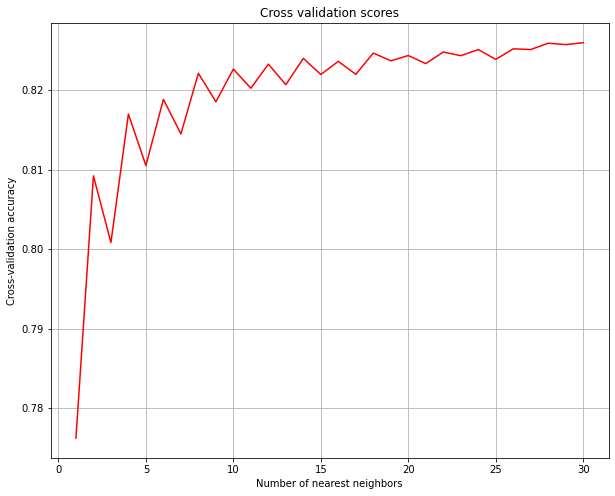

In [44]:
#Plot the measure CV scores to easily see which neighbor value has highest accuracy
plt.figure(figsize=(10,8))
plt.title("Cross validation scores")
plt.xlabel("Number of nearest neighbors")
plt.ylabel("Cross-validation accuracy")
plt.grid()
plt.plot(range(1,31),n_scores,c='Red')

In [45]:
#Run the model with the CV measured best hyperparameters
KNN_CV = KNeighborsClassifier(n_neighbors=14)
scores = cross_val_score(KNN_CV, X1, y1, cv=5, scoring = 'accuracy') 
print("{:.3f}".format(scores.mean()))

0.824


## Grid Search

In [46]:
n_range=list(range(1,31))
weight_range=['uniform','distance']
#m_range=[ 'minkowski','chebyshev','wminkowski','seuclidean','mahalanobis']
#algo_range=['auto','ball_tree','kd_tree','brute']
para_grid=dict(n_neighbors=n_range,weights=weight_range)
#,weight=weight_range)
#,metric=m_range,algorithm=algo_range)
print(para_grid)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 'weights': ['uniform', 'distance']}


In [47]:
#Use grid search to find the best hyperparameter
KNN_GS = KNeighborsClassifier(n_neighbors=5)
KNN_GS.get_params().keys()
grid = GridSearchCV(KNN_GS,para_grid,cv=5,scoring="accuracy",return_train_score=False)
grid.fit(X1,y1)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [48]:
#Print the grid search measured best hyperparameters
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.825947626846846
{'n_neighbors': 30, 'weights': 'uniform'}
KNeighborsClassifier(n_neighbors=30)


## Random Search

In [49]:
n_range=list(range(1,31))
weight_range=['uniform','distance']
para_rand=dict(n_neighbors=n_range,weights=weight_range)
#,metric=m_range,algorithm=algo_range)
print(para_rand)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 'weights': ['uniform', 'distance']}


In [50]:
#Use random search to find the best hyperparemeters
KNN_RS = KNeighborsClassifier(n_neighbors=5)
rand = RandomizedSearchCV(KNN_RS,para_rand,cv=5,scoring="accuracy",n_iter=10,random_state=0,return_train_score=False)
rand.fit(X1,y1)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(),
                   param_distributions={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8,
                                                        9, 10, 11, 12, 13, 14,
                                                        15, 16, 17, 18, 19, 20,
                                                        21, 22, 23, 24, 25, 26,
                                                        27, 28, 29, 30],
                                        'weights': ['uniform', 'distance']},
                   random_state=0, scoring='accuracy')

In [51]:
#Print the random search measured best hyperparameters
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.825947626846846
{'n_neighbors': 30, 'weights': 'uniform'}
KNeighborsClassifier(n_neighbors=30)


## Bayesian Search

In [52]:
n_range=list(range(1,31))
weight_range=['uniform','distance']
para_bayes=dict(n_neighbors=n_range,weights=weight_range)
print(para_bayes)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 'weights': ['uniform', 'distance']}


In [53]:
#Use bayesian serach to find the best hyperparameter
KNN_BS = KNeighborsClassifier(n_neighbors=5)
bayes = BayesSearchCV(KNN_BS,para_rand,cv=5,scoring="accuracy",n_iter=10,random_state=0,return_train_score=False)
bayes.fit(X1,y1)

BayesSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=10, random_state=0,
              scoring='accuracy',
              search_spaces={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                             12, 13, 14, 15, 16, 17, 18, 19, 20,
                                             21, 22, 23, 24, 25, 26, 27, 28, 29,
                                             30],
                             'weights': ['uniform', 'distance']})

In [54]:
#Print the bayesian search measured best hyperparameters
print(bayes.best_score_)
print(bayes.best_params_)
print(bayes.best_estimator_)

0.8257043032152492
OrderedDict([('n_neighbors', 29), ('weights', 'uniform')])
KNeighborsClassifier(n_neighbors=29)
